In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  

In [2]:
# import from pythin packages
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf as xe

import cmocean

from datetime import datetime, date, timedelta

# import from pre-built data classes
from data_handler import *
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from region import Region
from utils import Utils as utls, Color as uc

In [3]:
# load dynamic ocean topography data from class
dot = DOT().ds.dot

# set up stweric height
sha = StericHeight(ssh_ref='DOT',
                   ssh=dot,
                   lwe=GRACE(from_file=False).ds.lwe_thickness,
                   msl=ERA5().ds.msl
                  ).get_sha()

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [4]:
sice = xr.open_dataset('../Research/data/PROCESSED/nsidc_sea_ice.nc').nsidc_nt_seaice_conc_monthly
regridder = xe.Regridder(sice,sha,'bilinear')
sice = regridder(sice)
dsic = sice.differentiate('time',datetime_unit='D')

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [5]:
# define a function to plot the dot, eha and sha for a defined region
def mini_cmt(axs,region,ttls):

    xy = ['latitude','longitude']
    
    # define mini function to crop a paticular variable to the region
    sha_rg = region.crop_da(sha.sha)
    ice_rg = region.crop_da(sice)
    
    # fig = plt.figure(figsize=(12,4))

    # ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1, projection=ccrs.SouthPolarStereo())
    # ax = plt.subplot2grid((1, 3), (0, 1), colspan=2, rowspan=1)
    ax0=axs[0]
    ax=axs[1]

    region.plot_region(ax=ax0,drop_cbar=True,sea='Small Southern Ocean')
    ax0.set_title(ttls[0],loc='left')
    
    # compute climatology
    cmt = sha_rg.groupby('time.month').mean('time',skipna=True)
    cmt_mean = cmt.mean(xy)

    cmt_ice = ice_rg.groupby('time.month').mean('time',skipna=True).mean(xy)

    for grp in sha_rg.groupby('time.year'):
        data = grp[1].groupby('time.month').mean()
        ax.plot(data.month,data.mean(xy),'-',label=grp[0],c=uc.SHA.value[1])
    ax.plot(cmt.month,cmt_mean.to_numpy(),'-',c=uc.SHA.value[0])
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.set_xlim([0.5,12.5])
    ax.grid()
    ax.set_ylabel('SHA (cm)',c=uc.SHA.value[0])
    ax.set_title(ttls[1],loc='left')
    
    ax2= ax.twinx()
    ax2.plot(cmt_ice.month,cmt_ice,c='dimgrey')
    #ax2.set_ylabel('dSIC/dt',c='dimgrey')
    ax2.set_ylabel('SIC',c='dimgrey')

    plt.tight_layout()



In [6]:
def get_axes():
      fig = plt.figure(figsize=(16,8))

      gs = fig.add_gridspec(2,2, width_ratios=[1,3])
      axs1=[fig.add_subplot(gs[0, 0],projection=ccrs.SouthPolarStereo()),
            fig.add_subplot(gs[0, 1:])]
      axs2=[fig.add_subplot(gs[1, 0],projection=ccrs.SouthPolarStereo()),
            fig.add_subplot(gs[1, 1:])]
      return fig,axs1,axs2


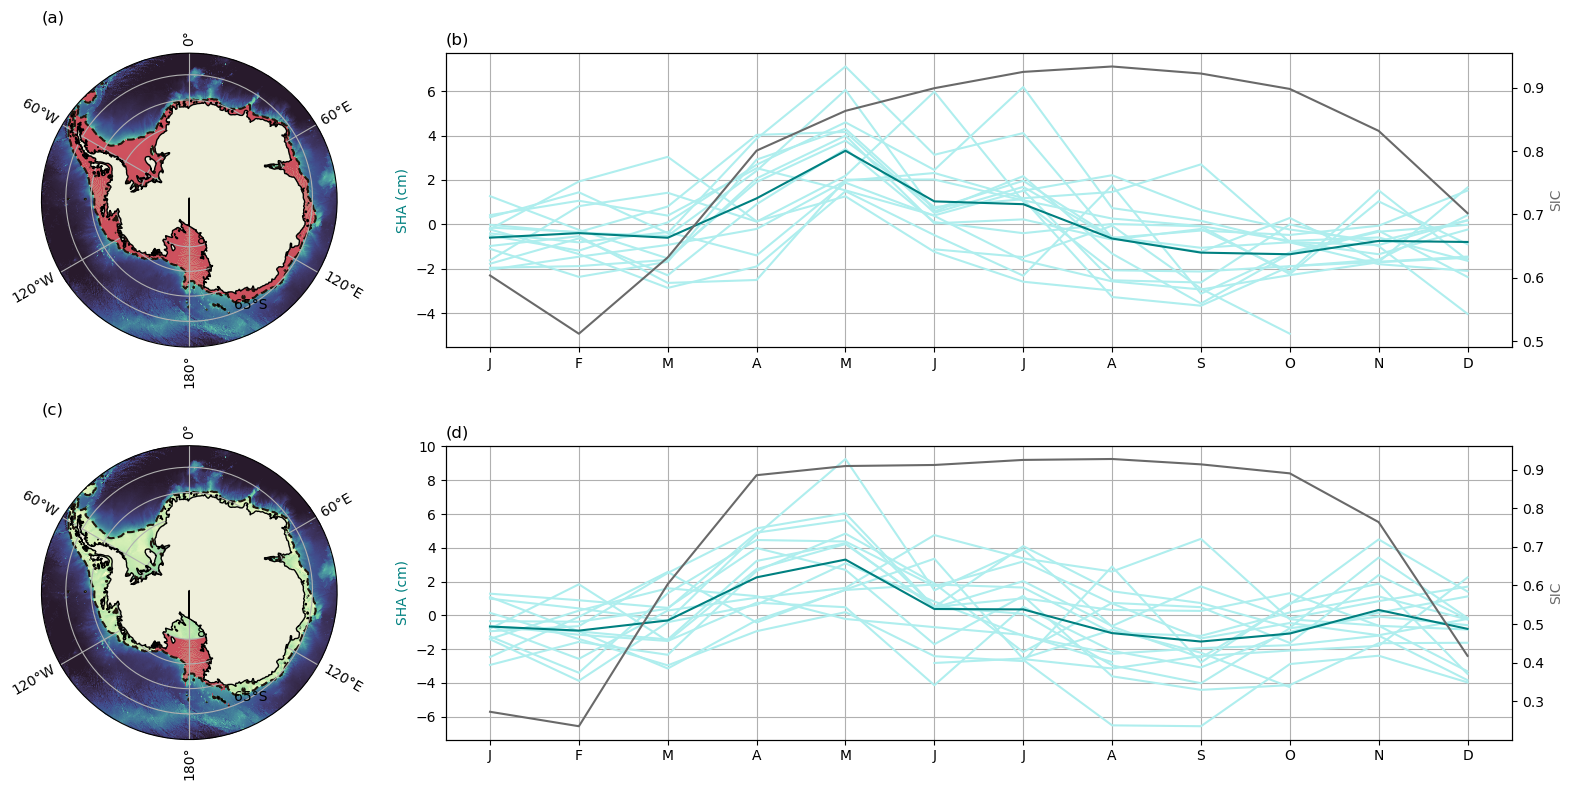

In [7]:
shelf = Region("South of 60S",min_elevation=-1000)
ross = Region("Ross Sea",min_elevation=-1000)
fig,axs1,axs2=get_axes()
mini_cmt(axs1,shelf,['(a)','(b)'])
mini_cmt(axs2,ross,['(c)','(d)'])

In [8]:
fig.savefig('plots/figureS1.png',dpi=200,transparent=False,bbox_inches='tight')